In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.dates as mdates
import datetime

## Data

In [6]:
import requests
import json

with open('key', 'r') as file:
    ckey = file.read()
symbol_id = 'ADA'
period_id = '1DAY'
time_start = '2019-05-03T00:00:00'
time_end = '2021-05-09T00:00:00'
limit = '1000'

url = f'https://rest.coinapi.io/v1/ohlcv/{symbol_id}/USD/history?period_id={period_id}&time_start={time_start}&time_end={time_end}&limit={limit}'
#url = 'https://rest.coinapi.io/v1/symbols'

headers = {
  'Accepts': 'application/json',
  'X-CoinAPI-Key': ckey,
}


response = requests.get(url, headers=headers)
data = json.loads(response.text)

In [7]:
df = pd.DataFrame(data)
df = df.drop(['time_period_end', 'time_open', 'time_close'], axis=1)
df['Date'] = pd.to_datetime(df['time_period_start']).dt.date
df = df.set_index(pd.DatetimeIndex(df['Date'])).drop(['time_period_start', 'Date'], axis=1)
df.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
Date,,,,,,
2019-05-03,0.067104,0.074000,0.066500,0.068826,1.105210e+07,1673
2019-05-04,0.069083,0.070949,0.065203,0.066269,8.567252e+06,1145
2019-05-05,0.066259,0.067266,0.064820,0.065500,3.166601e+06,388
2019-05-06,0.065252,0.068150,0.062891,0.066150,4.416848e+06,774
2019-05-07,0.066446,0.068239,0.062900,0.063100,5.940077e+06,1024


In [8]:
df.tail()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
Date,,,,,,
2021-05-04,1.3643,1.3681,1.257660,1.2719,1.145964e+08,186570
2021-05-05,1.2716,1.5000,1.260900,1.4813,2.003925e+08,283363
2021-05-06,1.4836,1.7050,1.426978,1.6503,3.079012e+08,443235
2021-05-07,1.6509,1.7499,1.530000,1.6551,2.001017e+08,342299
2021-05-08,1.6559,1.6569,1.563307,1.6250,1.123797e+08,238721


<AxesSubplot:xlabel='Date'>

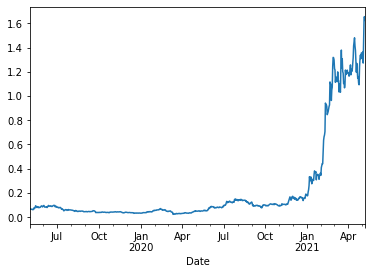

In [9]:
df['price_close'].plot()

In [41]:
forecast = 7
data = df.drop(['volume_traded', 'trades_count'], axis=1).apply(np.log).values
X_train, X_test = data[1:len(data)-forecast], data[len(data)-forecast:]

In [38]:
varmod = VAR(X_train)
varmod_fit = varmod.fit(200)
X_hat = varmod_fit.forecast(X_train, steps=7)

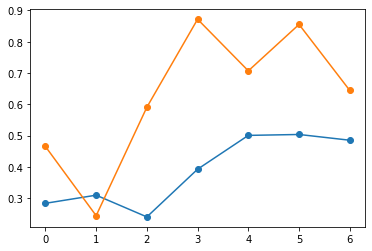

In [39]:
plt.plot(X_test[:,3], marker='o')
plt.plot(X_hat[:,3], marker='o')

In [33]:
X_test[:,3]

array([0.28397521, 0.30998158, 0.24051185, 0.39292008, 0.50095709,
       0.50386143, 0.48550782])

In [31]:
data[len(data)-7:]

array([[ 0.30269383,  0.30564477,  0.25871531,  0.28397521, 11.42659386],
       [ 0.28397521,  0.32324225,  0.27937264,  0.30998158, 11.79381703],
       [ 0.31064148,  0.31342292,  0.22925285,  0.24051185, 12.13656178],
       [ 0.24027595,  0.40546511,  0.23182575,  0.39292008, 12.55448404],
       [ 0.39447157,  0.53356511,  0.35555892,  0.50095709, 13.00185538],
       [ 0.50132059,  0.55955864,  0.42526774,  0.50386143, 12.7434399 ],
       [ 0.50434467,  0.50494839,  0.44680345,  0.48550782, 12.38305078]])

In [45]:
def hit_rate(true, pred):
    is_neg = lambda x: 0 if x > 0 else 1
    true = true[:,3]
    pred = pred[:,3]
    pos_true = []
    pos_hat = []
    for t in range(len(true)-1):
        pos_true.append(is_neg(np.sign(true[t] - true[t+1])))
        pos_hat.append(is_neg(np.sign(pred[t] - pred[t+1])))
    subtracted = np.abs(np.subtract(pos_hat, pos_true))
    rate = 1 - sum(subtracted)/len(subtracted)
    return rate

def find_returns(true, pred):
    true = true[:,3]
    pred = pred[:,3]
    ret_true = []
    ret_hat = []
    for t in range(len(true)-1):
        ret_true.append(((true[t+1] - true[t])/true[t])*100)
        ret_hat.append(((pred[t+1] - pred[t])/pred[t])*100)
    mse = mean_squared_error(ret_true, ret_hat)
    return ret_true, ret_hat, mse
        

def model_selection(data, forecast, dates, optimization='RET'):
    X_train, X_test = data[1:len(data)-forecast], data[len(data)-forecast:]
    dates_test = dates[len(dates)-forecast:]
    # find lag values which maximize hit rate
    rates = []
    for lag in range(1,int(len(X_train)/2)-1):
        print(lag)
        varmod = VAR(X_train).fit(lag)
        X_hat = varmod.forecast(X_train, forecast)
        rates.append(hit_rate(X_test, X_hat))
    
    max_hit_lags = [i for i, j in enumerate(rates) if j == max(rates)]
    
    # find lag values which maximize correct returns
    returns = []
    for lag in max_hit_lags:
        varmod = VAR(X_train).fit(lag)
        X_hat = np.exp(varmod.forecast(X_train, forecast))
        returns.append(find_returns(np.exp(X_test), X_hat))
    
    if optimization == 'RET':
        mses = [ret[2] for ret in returns]
        min_mse_lags = [max_hit_lags[i] for i,j in enumerate(mses) if j == min(mses)]
        
    elif optimization == 'MSE':
        # find lag values which minimize close price MSE
        mses = []
        for lag in max_hit_lags:
            varmod = VAR(X_train).fit(lag)
            X_hat = varmod.forecast(X_train, forecast)
            mses.append(mean_squared_error(X_test, X_hat))
    
        min_mse_lags = [max_hit_lags[i] for i, j in enumerate(mses) if j == min(mses)]
    
    best_returns = [returns[i] for i,j in enumerate(mses) if j == min(mses)]
    
    # Fit model
    lag_order = min_mse_lags[0]
    varmod = VAR(X_train).fit(lag_order)
    X_hat = varmod.forecast(X_train, forecast)
    
    df_returns = pd.DataFrame(data={'returns_true':best_returns[0][0] , 'returns_pred':best_returns[0][1]})
    
    fig, ax = plt.subplots()
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    ax.plot(dates_test, np.exp(X_test), marker='o', label='Observed')
    ax.plot(dates_test, np.exp(X_hat), marker='o', label='Predicted')
    fig.suptitle(f'{len(X_test)}-Day Prediction (Test Set)')
    ax.set_ylabel('Close Price (USD)')
    ax.set_xlabel('Date')
    ax.tick_params('x', labelsize=10)
    ax.legend()
    fig.autofmt_xdate()
    
    print("Lag:", lag_order)
    print("Hit rate:", rates[lag_order])
    print("Mean Squared Error:", min(mses))
    print(df_returns.head())
    
    
    return min_mse_lags[0]

In [ ]:
# Create a list of actions based on the percent change of the 
def hilo(pred_data):
    actions = []
    bought = False
    for t in range(len(pred_data)):
        if t == (len(pred_data)-1):
            if pred_data[t] > pred_data[t-1]:
                if bought:
                    actions.append((pred_data[t], 'sell'))
            else:
                if bought:
                    pass
                else:
                    actions.append((pred_data[t], 'wait'))
            continue
        if pred_data[t+1] >= pred_data[t]:
            if bought:
                actions.append((pred_data[t], 'hold'))
            else:
                actions.append((pred_data[t], 'buy'))
                bought = True
        else:
            if bought:
                actions.append((pred_data[t], 'sell'))
                bought = False
            else:
                actions.append((pred_data[t], 'wait'))
    return actions

def transactions(actions, returns, capital, fee=0.01):
    money = capital
    holdings = []
    total_percent = 0.0
    cost = capital
    r = 0
    for action in actions:
        if 'buy' in action[1]:
            cost += fee*money
            total_percent += returns[r]
            holdings.append(money)
        elif 'sell' in action[1]:
            money = money + (money*(total_percent/100))
            cost += fee*money
            total_percent = 0.0
            holdings.append(money)
        elif 'hold' in action[1]:
            total_percent += returns[r]
            holdings.append(money + (money*(total_percent/100)))
        else:
            holdings.append(money)
        r += 1
    return holdings, money - capital - (cost-capital), cost
            
def short_term_trade_ar(data, forecast, capital, dates, optimization='RET'):
    
    action_colors = {
        'buy': 'b',
        'sell': 'g',
        'hold': 'y',
        'wait': 'r'
    }
    
    # model selection (lag order based on minimization)
    lag_order = model_selection(data, forecast, dates, optimization)
    
    autoreg = AutoReg(X, lags=lag_order, old_names=True).fit()
    X_hat = np.exp(autoreg.forecast(forecast))
    
    # plotting new out-of-set prediction
    forecasted_dates = [dates[-1] + datetime.timedelta(days=t) for t in range(1,forecast+1)]
    
    trade_actions = hilo(X_hat)
    
    fig, ax = plt.subplots()
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    ax.plot(forecasted_dates,X_hat, marker='o')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price (USD)')
    fig.suptitle(f'{forecast}-Day Forecast (Future Days)')
    ax.tick_params('x', labelsize=10)
    fig.autofmt_xdate()
    
    returns = []
    for t in range(len(X_hat)-1):
        returns.append(((X_hat[t+1] - X_hat[t])/X_hat[t])*100)
        
    prices, profit, cost = transactions(trade_actions, returns, capital)
    print(f"Profit (USD): {profit}")
    print(f"Trade Costs (USD): {cost}")
    
    df_actions = pd.DataFrame(trade_actions, columns=['close','action'])
    df_actions['percent_change'] = [0.0] + returns
    df_actions['value'] = prices
    df_actions.index = forecasted_dates
    
    fig, ax = plt.subplots()
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    already_used = set()
    for p in range(len(forecasted_dates)):
        if df_actions['action'][p] not in already_used:
            ax.scatter(forecasted_dates[p], df_actions['value'][p], 
                       c=action_colors[df_actions['action'][p]], 
                       label=df_actions['action'][p])
            already_used.add(df_actions['action'][p])
        else:
            ax.scatter(forecasted_dates[p], df_actions['value'][p], 
                       c=action_colors[df_actions['action'][p]])
    ax.plot(forecasted_dates, df_actions['value'], zorder=0)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value (USD)')
    fig.suptitle(f'{forecast}-Day Forecast Trading')
    ax.tick_params('x', labelsize=10)
    fig.autofmt_xdate()
    ax.legend()
    
    return trade_actions, df_actions, profit, capital
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


69

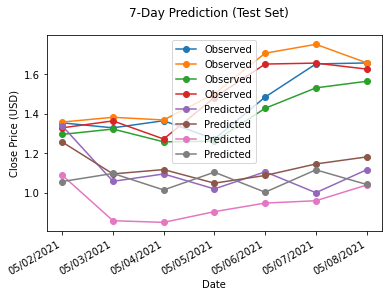

In [46]:
model_selection(data, 7, df.index)